In [1]:
import pandas as pd
import numpy as np
import requests
import json
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import math

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_colwidth', None)

# Loading, looping through, flattening, and formatting the Json file from the API Querying Notebook
Here I am defining a function to pull the data I want from the queried json files.

The format is divided into teams, which is why we loop through each team color (there are only blue and orange for Rocket League). I then pull player info and loop through each player for their stats. Specifically player_id and player_name sometimes had nulls (as some players use weird characters for names that do not translate well onto ballchasing.com and result in nulls), so setting a placeholder for the few instances of that was necessary. 

In [4]:
def load_and_flatten_data(filename):
    flattened_data = []
    with open(filename, 'r') as file:
        for line in file:
            replays = json.loads(line)
            for replay in replays:
                replay_id = replay.get('id')
                for team_color in ['blue', 'orange']:
                    team = replay.get(team_color, {})
                    players = team.get('players', [])
                    for player in players:
                        player_stats = player.get('stats', {})
                        flattened_stats = {
                            'replay_id': replay_id,
                            'player_id': player['id'].get('id', 'Unknown ID'),
                            'player_name': player.get('name', 'Unknown Name'),
                            'team_color': team_color,
                            **{k: v for section in player_stats.values() for k, v in section.items()}
                        }
                        flattened_data.append(flattened_stats)
    return pd.DataFrame(flattened_data)


filename = 'C:/Users/nickh/Desktop/BrainStation Course/Capstone Project RL/All_Data_50k_to_100k_No_Processing.json'
df_test = load_and_flatten_data(filename)

In [5]:
df_test.shape

(299797, 88)

# EDA/Feature Engineering
The EDA for this dataset did not require much, since the data coming from ballchasing.com was already quite robust. Most of my time for this part was spent on feature engineering and utilizing my knowledge of the game to make decisions on what to include and how to handle the data

### Important EDA Finding
Below is a list of all the stats that are available for each player in each game. There are many stats that have two formats, either percentage or time, of which I picked percentage in every case. This was due to the fact that, in Rocket League, quite a few games end in a forfeit either due to rage quitting or one team is simply up to much and the other team forfeits. In a game that was forfeit, a player may have done very well but still have a lower score on a stat that only showed total time. The stats that use percentage would not be affected by a game that ran for less than the full 5 minutes, or for that matter, over 5 minutes in the event of an overtime (if scores are tied at the end of the game).

In [6]:
df_test.columns

Index(['replay_id', 'player_id', 'player_name', 'team_color', 'shots',
       'shots_against', 'goals', 'goals_against', 'saves', 'assists', 'score',
       'mvp', 'shooting_percentage', 'bpm', 'bcpm', 'avg_amount',
       'amount_collected', 'amount_stolen', 'amount_collected_big',
       'amount_stolen_big', 'amount_collected_small', 'amount_stolen_small',
       'count_collected_big', 'count_stolen_big', 'count_collected_small',
       'count_stolen_small', 'amount_overfill', 'amount_overfill_stolen',
       'amount_used_while_supersonic', 'time_zero_boost', 'percent_zero_boost',
       'time_full_boost', 'percent_full_boost', 'time_boost_0_25',
       'time_boost_25_50', 'time_boost_50_75', 'time_boost_75_100',
       'percent_boost_0_25', 'percent_boost_25_50', 'percent_boost_50_75',
       'percent_boost_75_100', 'avg_speed', 'total_distance',
       'time_supersonic_speed', 'time_boost_speed', 'time_slow_speed',
       'time_ground', 'time_low_air', 'time_high_air', 'time_powers

### Creating the y Variable we want to Predict
Since there was no column in the dataset that showed a win or loss, I created a new column that compared the 'goals_against' column for each team to find out which team won, and then applied that value accordingly across all 6 players (with 1 row being one player's stats/data) in the new column.

In [6]:
def assign_win_loss(group):
    goals_against_blue = group[group['team_color'] == 'blue']['goals_against'].iloc[0]
    goals_against_orange = group[group['team_color'] == 'orange']['goals_against'].iloc[0]
    
    if goals_against_blue < goals_against_orange:
        group['win'] = group['team_color'].apply(lambda x: 1 if x == 'blue' else 0)
    else:
        group['win'] = group['team_color'].apply(lambda x: 1 if x == 'orange' else 0)
    
    return group


In [7]:
# applying the win/loss function to the dataset
df_test_wins = df_test.groupby('replay_id').apply(assign_win_loss).reset_index(drop=True)

In [8]:
# testing for nulls
df_test_wins.isna().sum()

replay_id                                  0
player_id                                  0
player_name                                0
team_color                                 0
shots                                      0
shots_against                              0
goals                                      0
goals_against                              0
saves                                      0
assists                                    0
score                                      0
mvp                                        0
shooting_percentage                        0
bpm                                        0
bcpm                                       0
avg_amount                                 0
amount_collected                           0
amount_stolen                              0
amount_collected_big                       0
amount_stolen_big                          0
amount_collected_small                     0
amount_stolen_small                        0
count_coll

### Important EDA Finding
As you can see in the head of the data below, every 6 rows is one game of Rocket League, with each row containing the stats for one player in the game. Teams are denoted by the 'team_color' column, of which there are only two values: blue (which is always first, as that is how the data comes from the API) and orange.

Due to this, before inputting the data into any model, I had to (further down in the notebook) flatten each team's data into a 2d array that contained all the stats for each player on that team, and then feed the two arrays into the models for training.

In [10]:
df_test_wins.head(6)

replay_id                         player_id  \
0  00014aaf-22c9-4712-a4ec-de28a60dbc6d                 76561198213154948   
1  00014aaf-22c9-4712-a4ec-de28a60dbc6d  d58a79bcdbbd4a86bc5c964037f53a25   
2  00014aaf-22c9-4712-a4ec-de28a60dbc6d                 76561198884555998   
3  00014aaf-22c9-4712-a4ec-de28a60dbc6d                 76561198089804347   
4  00014aaf-22c9-4712-a4ec-de28a60dbc6d                 76561198796710434   
5  00014aaf-22c9-4712-a4ec-de28a60dbc6d  b1210f550f274a43a88daea74196a8a4   

        player_name team_color  shots  shots_against  goals  goals_against  \
0             David       blue      5              6      2              1   
1  EnigmaaaaaaaaaRL       blue      4              6      0              1   
2                AJ       blue      2              6      0              1   
3              noah     orange      1             11      1              2   
4        lil savage     orange      5             11      0              2   
5     The_One_Scope     orange      0             11      0              2   

   saves  assists  score    mvp  shooting_percentage  bpm       bcpm  \
0      3        0    622   True                 40.0  279  269.47995   
1      2        2    422  False                  0.0  476  516.80884   
2      0        0    196  False                  0.0  387  389.03693   
3      3        0    412  False                100.0  364  355.44363   
4      1        1    306  False                  0.0  268  278.72177   
5      2        0    265  False                  0.0  323  324.78424   

   avg_amount  amount_collected  amount_stolen  amount_collected_big  \
0       45.09              1837            598                   857   
1       55.80              3523           1121                  2581   
2       56.89              2652            567                  2012   
3       39.08              2423            363                  1479   
4       50.17              1900            683                  1208   
5       52.21              2214            396                  1503   

   amount_stolen_big  amount_collected_small  amount_stolen_small  \
0                231                     980                  367   
1                786                     942                  335   
2                395                     640                  172   
3                100                     944                  263   
4                436                     692                  247   
5                282                     711                  114   

   count_collected_big  count_stolen_big  count_collected_small  \
0                   11                 3                     85   
1                   34                10                     92   
2                   27                 5                     58   
3                   17                 1                     80   
4                   16                 5                     61   
5                   18                 5                     60   

   count_stolen_small  amount_overfill  amount_overfill_stolen  \
0                  32              254                      73   
1                  35              894                     240   
2                  17              383                     108   
3                  22              133                       0   
4                  22              412                      80   
5                  10              316                     217   

   amount_used_while_supersonic  time_zero_boost  percent_zero_boost  \
0                           119            24.59            6.012078   
1                           617            43.46           10.625657   
2                           216            62.55           15.293024   
3                           261           128.48           31.412434   
4                            64            37.52            9.173369   
5                           100            50.95           12.456908   

   time_ful

In [70]:
# df_test_wins.to_csv('C:/Users/nickh/Desktop/BrainStation Course/Capstone Project RL/FullData0to35000.csv')

## More EDA

First, I dropped many columns that, using my game knowledge, I knew would not be as highly correlated to wins as the others.

I then convert all the numeric columns to float64, as some came as num64 and some as float64, so just for consistancy and modeling purposes. As well as changing the 'win' column to boolean.

In [9]:
# removing obviously unneccessary columns first
df_dropped1 = df_test_wins.drop(columns=[
    'shots', 
    'shots_against', 
    'goals', 
    'goals_against',
    'saves',
    'assists',
    'score',
    'mvp',
    'shooting_percentage',
    'goals_against_while_last_defender',
    'avg_amount',
    'count_collected_big',
    'count_stolen_big',
    'count_collected_small',
    'count_stolen_small',
    'time_zero_boost',
    'time_full_boost',
    'time_boost_0_25',
    'time_boost_25_50',
    'time_boost_50_75',
    'time_boost_75_100',
    'total_distance',
    'percent_defensive_half',
    'percent_offensive_half',
    'inflicted',
    'taken'
])

In [10]:
df_dropped1.shape

(299797, 63)

In [40]:
df_dropped1.columns

Index(['replay_id', 'player_id', 'player_name', 'team_color', 'bpm', 'bcpm',
       'amount_collected', 'amount_stolen', 'amount_collected_big',
       'amount_stolen_big', 'amount_collected_small', 'amount_stolen_small',
       'amount_overfill', 'amount_overfill_stolen',
       'amount_used_while_supersonic', 'percent_zero_boost',
       'percent_full_boost', 'percent_boost_0_25', 'percent_boost_25_50',
       'percent_boost_50_75', 'percent_boost_75_100', 'avg_speed',
       'time_supersonic_speed', 'time_boost_speed', 'time_slow_speed',
       'time_ground', 'time_low_air', 'time_high_air', 'time_powerslide',
       'count_powerslide', 'avg_powerslide_duration', 'avg_speed_percentage',
       'percent_slow_speed', 'percent_boost_speed', 'percent_supersonic_speed',
       'percent_ground', 'percent_low_air', 'percent_high_air',
       'avg_distance_to_ball', 'avg_distance_to_ball_possession',
       'avg_distance_to_ball_no_possession', 'avg_distance_to_mates',
       'time_defensiv

In [11]:
columns_to_convert = [
    'bpm', 'amount_collected', 'amount_stolen', 'amount_collected_big',
    'amount_stolen_big', 'amount_collected_small', 'amount_stolen_small',
    'amount_overfill', 'amount_overfill_stolen', 'amount_used_while_supersonic',
    'avg_speed', 'count_powerslide', 'avg_distance_to_ball',
    'avg_distance_to_ball_possession', 'avg_distance_to_ball_no_possession'
]

df_dropped1[columns_to_convert] = df_dropped1[columns_to_convert].astype('float64')


In [12]:
df_dropped1['win'] = df_dropped1['win'].astype(bool)

In [13]:
df_dropped1.dtypes

replay_id                              object
player_id                              object
player_name                            object
team_color                             object
bpm                                   float64
bcpm                                  float64
amount_collected                      float64
amount_stolen                         float64
amount_collected_big                  float64
amount_stolen_big                     float64
amount_collected_small                float64
amount_stolen_small                   float64
amount_overfill                       float64
amount_overfill_stolen                float64
amount_used_while_supersonic          float64
percent_zero_boost                    float64
percent_full_boost                    float64
percent_boost_0_25                    float64
percent_boost_25_50                   float64
percent_boost_50_75                   float64
percent_boost_75_100                  float64
avg_speed                         

In [28]:
df_dropped1.tail(6)

replay_id                         player_id  \
89992  fffd08c7-c7e5-4d40-ad3e-c8ac947dfad8  8b504757dfb64360b9cb2c3ba9dfdde5   
89993  fffd08c7-c7e5-4d40-ad3e-c8ac947dfad8  525067367a89426aa4270ca8a6f3cddb   
89994  fffd08c7-c7e5-4d40-ad3e-c8ac947dfad8  11563443cc1d4d0f89890bd00f080323   
89995  fffd08c7-c7e5-4d40-ad3e-c8ac947dfad8                 76561198345606853   
89996  fffd08c7-c7e5-4d40-ad3e-c8ac947dfad8                 76561198162589533   
89997  fffd08c7-c7e5-4d40-ad3e-c8ac947dfad8  ef443d0c3b574d70ab8f19ce0055c192   

        player_name team_color    bpm       bcpm  amount_collected  \
89992  FanisDaGoat.       blue  468.0  478.24402            3290.0   
89993       OG evdo       blue  355.0  371.40225            2555.0   
89994   Yeray231102       blue  249.0  280.98650            1933.0   
89995          Tony     orange  360.0  359.04642            2470.0   
89996          Toma     orange  376.0  397.42220            2734.0   
89997         Inzok     orange  287.0  339.71313            2337.0   

       amount_stolen  amount_collected_big  amount_stolen_big  \
89992          631.0                2683.0              387.0   
89993          576.0                1991.0              441.0   
89994          672.0                1552.0              525.0   
89995          503.0                1800.0              367.0   
89996         1141.0                1905.0              895.0   
89997          177.0                1584.0                0.0   

       amount_collected_small  amount_stolen_small  amount_overfill  \
89992                   607.0                244.0            519.0   
89993                   564.0                135.0            244.0   
89994                   381.0                147.0            565.0   
89995                   670.0                136.0            218.0   
89996                   829.0                246.0            216.0   
89997                   753.0                177.0            229.0   

       amount_overfill_stolen  amount_used_while_supersonic  \
89992                   123.0                         120.0   
89993                    67.0                         119.0   
89994                   174.0                          71.0   
89995                    33.0                         273.0   
89996                   123.0                         207.0   
89997                     3.0                          81.0   

       percent_zero_boost  percent_full_boost  percent_boost_0_25  \
89992           14.533869           11.229285           21.946232   
89993           12.966373           17.298187           30.677387   
89994            5.128888           27.921795           15.048867   
89995            9.470394           15.590173           30.955467   
89996            9.991278            6.873243           30.487072   
89997           12.934877            7.171238           26.163763   

       percent_boost_25_50  percent_boost_50_75  percent_boost_75_100  \
89992            23.785980            16.053812             38.213970   
89993            17.984210            20.555101             30.783304   
89994            17.765680            27.900530             39.284916   
89995            18.796312            17.629795             32.618423   
89996            27.771498            18.544798             23.196632   
89997            24.454525            23.683456             25.698257   

       avg_speed  time_supersonic_speed  time_boost_speed  time_slow_speed  \
89992     1602.0                  87.22            169.50           169.57   
89993     1468.0                  50.79            166.49           210.24   
89994     1334.0                  20.25            139.27           267.03   
89995     1518.0                  42.68            187.89           194.40   
89996     1497.0                  52.69            165.16           206.17   
89997     1404.0                  24.90            176.52           225.97   

       time_ground  time_low_air  ti

### Note
Due to some errors occurring in the querying of the API, I ended up with two seperate dataframes that I had to combine into one before more processing occurred. Below, I am just loading in, checking the shape of, and concatenating them together to create my final dataset of approx. 300,000 rows for modeling.

In [ ]:
# df_dropped2 = pd.read_csv('C:/Users/nickh/Desktop/BrainStation Course/Capstone Project RL/FullData0to35000.csv')

In [14]:
df_dropped1.shape

(299797, 63)

In [31]:
df_dropped2.shape

(209994, 63)

In [29]:
df_dropped2 = df_dropped2.drop(columns=[
    'Unnamed: 0'])

In [32]:
# combining the data pulled from the API. df_dropped1 is games 35,000-50,000, df_dropped2 is games 1-35,000
df_combined = pd.concat([df_dropped2, df_dropped1], ignore_index=True)


In [23]:
df_combined.shape

(299797, 63)

### Filling Nulls
There were very few nulls in this dataset to begin with, so picking either median or mean to fill the values with was a fairly arbitrary choice, as the tiny number of filled nulls would hardly affect the outcome of the modeling. I decided to go with median, as the data on ballchasing.com tends to have more stats from higher level players (as higher level players are more likely to set up their account to upload their games to ballchasing so they can track their own stats), and so to mitigate a higher than average value for the nulls, median is less affected by outliers.

In [17]:
df_combined.describe()

bpm           bcpm  amount_collected  amount_stolen  \
count  299797.000000  299797.000000     299797.000000  299797.000000   
mean      357.155739     372.055665       2013.262921     437.537030   
std        69.399588      70.557066        601.082788     223.640463   
min         0.000000       0.000000          0.000000       0.000000   
25%       313.000000     327.191380       1662.000000     277.000000   
50%       360.000000     374.603500       2016.000000     412.000000   
75%       404.000000     419.259250       2349.000000     569.000000   
max      1118.000000    1898.734100       8096.000000    3019.000000   

       amount_collected_big  amount_stolen_big  amount_collected_small  \
count         299797.000000      299797.000000           299797.000000   
mean            1403.631047         258.451125              609.631874   
std              490.426190         179.235726              205.481192   
min                0.000000           0.000000                0.000000   
25%             1085.000000         114.000000              483.000000   
50%             1396.000000         234.000000              600.000000   
75%             1700.000000         365.000000              723.000000   
max             6296.000000        2130.000000             2621.000000   

       amount_stolen_small  amount_overfill  amount_overfill_stolen  \
count        299797.000000    299797.000000           299797.000000   
mean            179.085905       324.721872               58.721385   
std              83.496238       177.401749               60.000329   
min               0.000000         0.000000                0.000000   
25%             121.000000       198.000000               10.000000   
50%             170.000000       300.000000               43.000000   
75%             226.000000       423.000000               88.000000   
max            1185.000000      2864.000000             1083.000000   

       amount_used_while_supersonic  percent_zero_boost  percent_full_boost  \
count                 299797.000000       299797.000000       299797.000000   
mean                     233.355117           10.487934           13.192669   
std                      155.311044            4.971429            5.837377   
min                        0.000000            0.000000            0.000000   
25%                      122.000000            6.930664            9.020104   
50%                      204.000000            9.957918           12.234920   
75%                      312.000000           13.434134           16.343412   
max                     2840.000000           71.740310           70.850200   

       percent_boost_0_25  percent_boost_25_50  percent_boost_50_75  \
count       299797.000000        299797.000000        299797.000000   
mean            29.892681            21.919576            19.390533   
std              8.930572             5.286195             5.224486   
min              0.000000             0.000000             0.000000   
25%             23.842936            18.388374            15.844953   
50%             29.703037            21.598133            19.059130   
75%             35.673070            25.058748            22.587006   
max            100.000000           100.000000            95.892350   

       percent_boost_75_100      avg_speed  time_supersonic_speed  \
count         299797.000000  299797.000000          299797.000000   
mean              28.776529    1494.261790              41.412885   
std                7.818008     109.676636              20.242110   
min                0.000000       0.000000               0.000000   
25%               23.471428    1427.000000              26.860000   
50%               28.234396    1499.000000              38.910000   
75%               33.521225    1567.000000              53.100000   
max              100.000000    2011.000000             269.410000   

       time_boost_speed  time_slow_speed    time_ground   time_low_air  \
count     299

In [20]:
columns_to_fill = [
    "time_most_back", "time_most_forward", "time_closest_to_ball", "time_farthest_from_ball",
    "percent_most_back", "percent_most_forward", "percent_closest_to_ball", "percent_farthest_from_ball", "avg_distance_to_mates"
]

for column in columns_to_fill:
    median_value = df_combined[column].median()
    df_combined[column] = df_combined[column].fillna(median_value)

In [21]:
# filling in nulls for a column that I missed above
median_value = df_combined['avg_distance_to_mates'].median()
df_combined['avg_distance_to_mates'] = df_combined['avg_distance_to_mates'].fillna(median_value)

In [ ]:
# saving the combined dataset to my computer

# df_combined.to_csv('C:/Users/nickh/Desktop/BrainStation Course/Capstone Project RL/FULLDATA0to50000DroppedAndReady.csv')

### Important EDA Finding
There were games that had less than 6 players (due to someone not loading into the game at the start, which happens periodically), so below I am first grouping by replay ID and checking if there were 5 or less rows for each unique replay ID to determine which IDs had a missing player, then since there were only about 10 instances of this in all the data, I hand copy-pasted the replay IDs into the second and third code cells below to double check and then remove those rows respectively.

In [22]:
incomplete_games = df_combined.groupby('replay_id').filter(lambda x: len(x) <= 5)

print(incomplete_games['replay_id'].unique())

['02bfe53c-64de-4353-9d54-3b4bf553d1f3'
 '1655fe50-f810-4047-a5d4-d1d78e41680d'
 '1cfdc712-b225-4a3a-9aba-7167f8bdf768'
 '2b94fbbe-780b-488e-a475-6e0dca3e0625'
 '39a20a76-357b-47b1-88cb-119f571078f0'
 '5dfcc7fb-49f3-4899-99c2-751c8aa76fc1'
 '8e3c609f-a591-4798-990a-247cf89ac487'
 '99a04c31-afe4-4eba-9eb4-7185670c85c3'
 '9a944794-1a58-4db9-a6e0-070c741af815'
 'dce7a117-5a02-4600-86b3-8b86a55597b8']


In [69]:
# searching by ID for games that had less than 6 players to verify before deleting those rows

filtered_df = df_combined.loc[df_combined['replay_id'] == 'dce7a117-5a02-4600-86b3-8b86a55597b8']

filtered_df


replay_id  \
181339  dce7a117-5a02-4600-86b3-8b86a55597b8   
181340  dce7a117-5a02-4600-86b3-8b86a55597b8   
181341  dce7a117-5a02-4600-86b3-8b86a55597b8   
181342  dce7a117-5a02-4600-86b3-8b86a55597b8   
181343  dce7a117-5a02-4600-86b3-8b86a55597b8   

                               player_id    player_name team_color    bpm  \
181339                     Bert_The_Herp  Bert_The_Herp       blue  347.0   
181340  027e59d7cf3f4d7d99ab7a37d13c18f5  Thiswasntaken       blue  152.0   
181341  5f7b69f656674aacabe74721ba8fb4f7          DTsar     orange  370.0   
181342  97845fa684db43af9d086c03b5aeecea       indimane     orange   57.0   
181343  cb2605e841a244adbb87f2347bbd6042      zxcursed      orange  329.0   

              bcpm  amount_collected  amount_stolen  amount_collected_big  \
181339   398.73416              21.0            0.0                   0.0   
181340     0.00000               0.0            0.0                   0.0   
181341     0.00000               0.0            0.0                   0.0   
181342   208.86075              11.0            0.0                   0.0   
181343  1898.73410             100.0            0.0                 100.0   

        amount_stolen_big  amount_collected_small  amount_stolen_small  \
181339                0.0                    21.0                  0.0   
181340                0.0                     0.0                  0.0   
181341                0.0                     0.0                  0.0   
181342                0.0                    11.0                  0.0   
181343                0.0                     0.0                  0.0   

        amount_overfill  amount_overfill_stolen  amount_used_while_supersonic  \
181339              0.0                     0.0                           0.0   
181340              0.0                     0.0                           0.0   
181341              0.0                     0.0                           0.0   
181342              0.0                     0.0                           0.0   
181343              0.0                     0.0                           0.0   

        percent_zero_boost  percent_full_boost  percent_boost_0_25  \
181339            0.000000                 0.0           20.000000   
181340            0.000000                 0.0            4.967602   
181341            0.000000                 0.0           17.962965   
181342            0.000000                 0.0            0.000000   
181343           32.911392                 0.0           82.866560   

        percent_boost_25_50  percent_boost_50_75  percent_boost_75_100  \
181339            80.000000                  0.0              0.000000   
181340            95.032394                  0.0              0.000000   
181341            82.037040                  0.0              0.000000   
181342           100.000000                  0.0              0.000000   
181343             0.000000                  0.0             17.133442   

        avg_speed  time_supersonic_speed  time_boost_speed  time_slow_speed  \
181339     1265.0                   0.83              0.24             4.90   
181340     1295.0                   0.00              1.24             4.67   
181341     1382.0                   0.13              1.20             4.57   
181342      328.0                   0.00              0.00             5.97   
181343     1289.0                   0.00              1.37             4.60   

        time_ground  time_low_air  time_high_air  time_powerslide  \
181339         4.90          1.07            0.0             0.07   
181340         4.57          1.34            0.0             0.00   
181341         5.67          0.23            0.0             0.00   
181342         4.83          1.14            0.0             0.00   
181343         4.73          1.24            0.0             0.00   

        count_powerslide  avg_powerslide_duration  avg_speed_percentage  \
181339               1.0                     0.07        

In [33]:
# removing games in the data that have less than 6 players
df_combined = df_combined[df_combined['replay_id'] != '02bfe53c-64de-4353-9d54-3b4bf553d1f3']


In [34]:
# double checking the shape and nulls before proceeding to modeling
df_combined.shape

(299748, 63)

In [35]:
df_combined.isna().sum()

replay_id                             0
player_id                             0
player_name                           0
team_color                            0
bpm                                   0
bcpm                                  0
amount_collected                      0
amount_stolen                         0
amount_collected_big                  0
amount_stolen_big                     0
amount_collected_small                0
amount_stolen_small                   0
amount_overfill                       0
amount_overfill_stolen                0
amount_used_while_supersonic          0
percent_zero_boost                    0
percent_full_boost                    0
percent_boost_0_25                    0
percent_boost_25_50                   0
percent_boost_50_75                   0
percent_boost_75_100                  0
avg_speed                             0
time_supersonic_speed                 0
time_boost_speed                      0
time_slow_speed                       0


# (SPRINT 3 ADDITIONS/ALTERATIONS START HERE!)

## Combining Old and New Data 
I queried the Ballchasing API for more data and have doubled the data set to 100,000 (approximately) games, resulting in around 600,000 rows in the dataframe, before flattening it back to 100k for the modeling.

In [3]:
old_data = pd.read_csv('C:/Users/nickh/Desktop/BrainStation Course/Capstone Project RL/FULLDATA0to50000DroppedAndReady.csv', index_col=0)

In [4]:
new_data = pd.read_csv('C:/Users/nickh/Desktop/BrainStation Course/Capstone Project RL/All_Data_50k_to_100k_YES_Processing.csv', index_col=0)

In [5]:
print(old_data.shape)
print(new_data.shape)

(299958, 63)
(299748, 63)


In [5]:
final_data = pd.concat([new_data, old_data], ignore_index=True)

In [6]:
final_data.shape

(599706, 63)

### Additional Cleaning Step
Below Im defining a function to take out the top and bottom .01% of the data and replacing those values with the average for that column. There were some extreme outliers I found and this cleans those up nicely while only affecting .02% of the dataset.

In [7]:
def outliers(df, threshold=0.0001):
    numeric_columns = df.select_dtypes(include=[np.number]).columns  # selecting all numeric columns
    
    for col in numeric_columns:  # iterating through each column
        lower_bound = df[col].quantile(threshold)  # calclating lower bound using threshold
        upper_bound = df[col].quantile(1 - threshold)  # calculating upper bound using threshold
        col_mean = df[col].mean()  # calculating mean of each column
        
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), col_mean, df[col]) # replacing outliers with mean of the column
    
    return df  # returning the dataframe with outliers handled

In [8]:
final_data = outliers(final_data)

### Defining the Feature Columns

In [9]:
feature_cols = ['bpm', 'bcpm', 'amount_stolen', 'percent_zero_boost',
       'percent_full_boost', 'avg_speed', 'percent_boost_speed', 'percent_high_air', 'avg_distance_to_mates', 'percent_offensive_third',
       'percent_neutral_third', 'percent_behind_ball', 'avg_distance_to_ball_possession']

# EDA Visualizations

### Data Distribution of Boost Features
Here we are looking at the distribution of data related to boost collection and usage. This mainly showed me that I needed to use the above outliers function to eliminate some extreme outliers. After doing so, I saw a much better and less cramped distribution here. Although this doesnt help me with feature egineering, it showed I needed that additional EDA step which Im sure helped the modeling process in general.

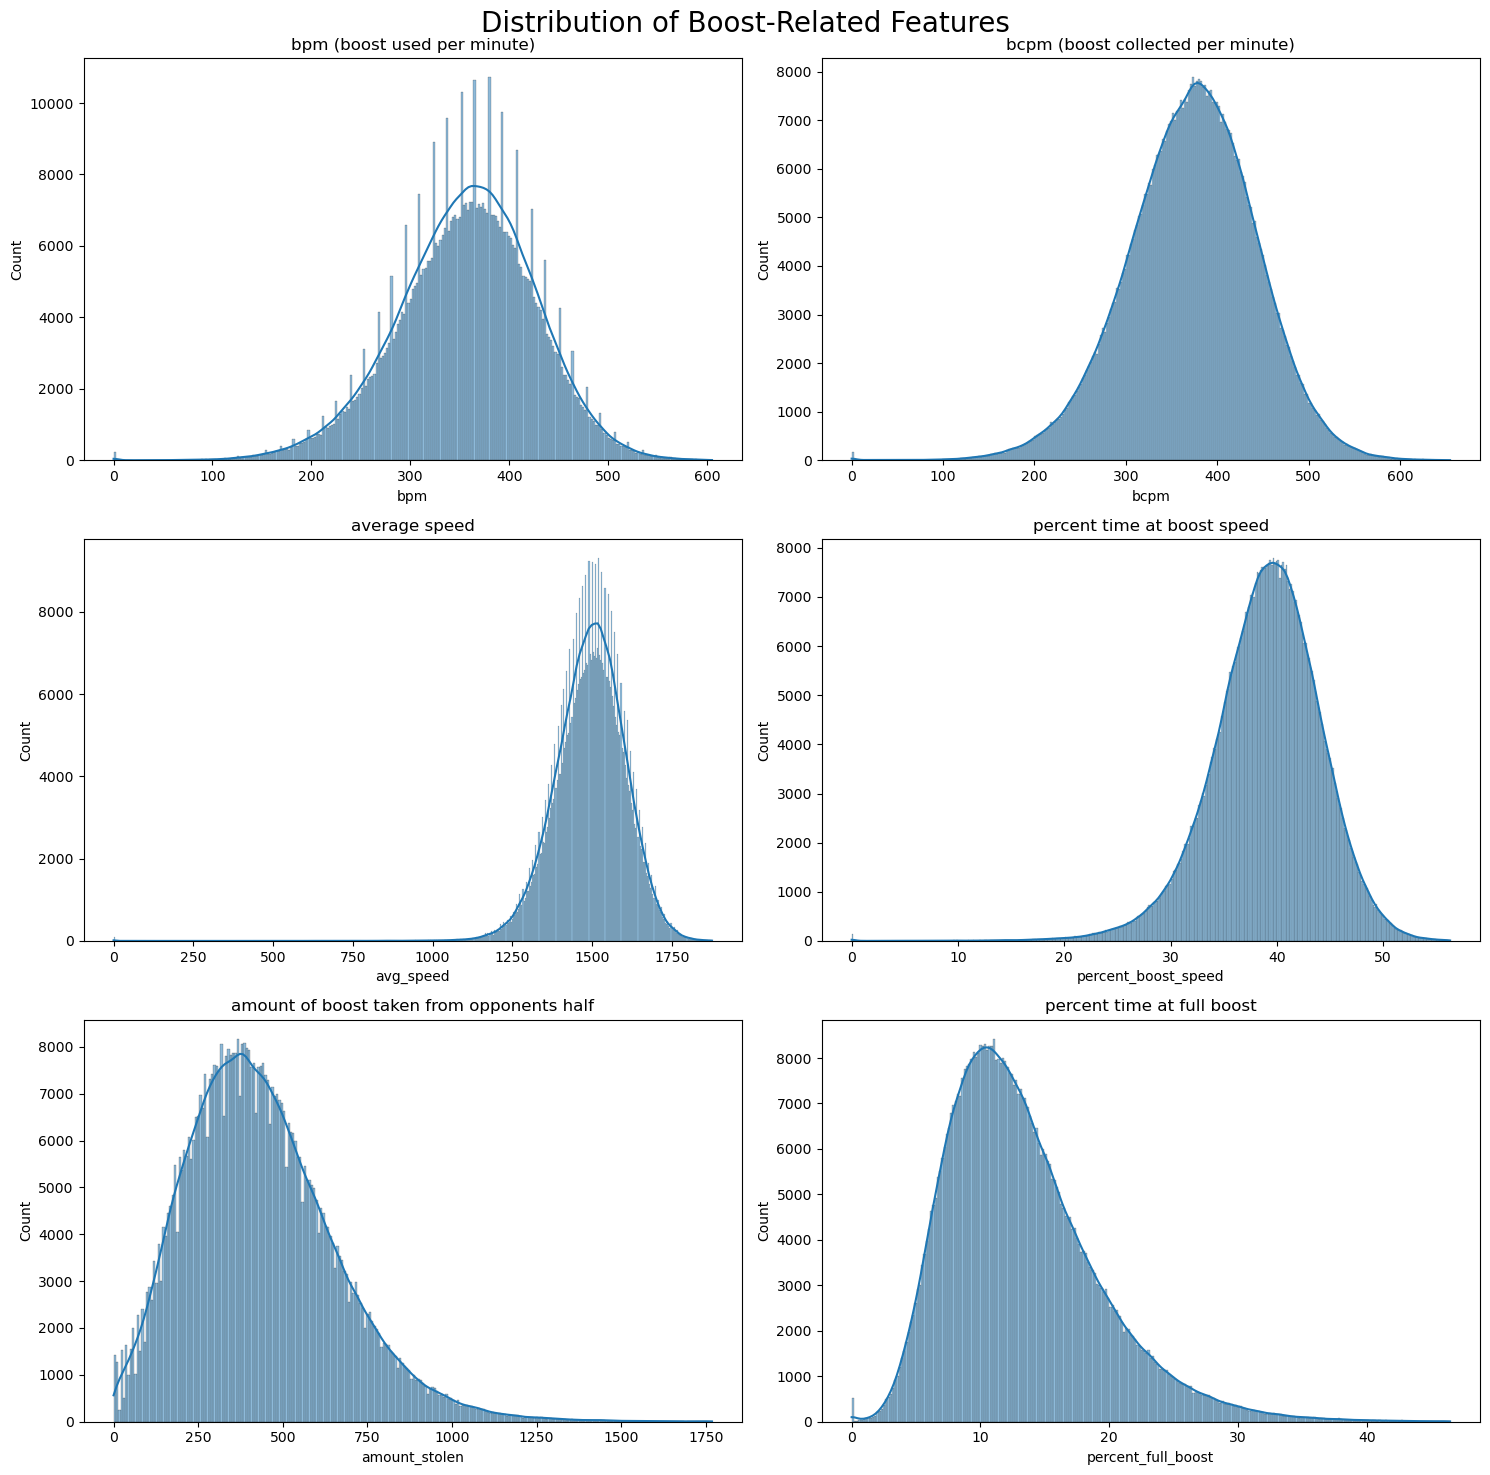

In [22]:
features1 = ['bpm', 'bcpm', 'avg_speed', 'percent_boost_speed', 'amount_stolen', 'percent_full_boost']
names1 = ['bpm (boost used per minute)', 'bcpm (boost collected per minute)', 'average speed', 'percent time at boost speed', 'amount of boost taken from opponents half', 'percent time at full boost']  # names for features

fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # creating a 3x2 grid of plots
fig.suptitle('Distribution of Boost-Related Features', fontsize=20)  # setting overall title


for i, (feature, name) in enumerate(zip(features1, names1)):  # iterating through features and names
    ax = axes[i//2, i%2]  # selecting the appropriate subplot
    sns.histplot(data=final_data, x=feature, kde=True, ax=ax)  # creating histogram with kernel density estimate
    ax.set_title(name, fontsize=12)  # title for each subplot
    ax.set_xlabel(feature)  # x-axis label

plt.tight_layout()  # better layout for this number of graphs
plt.show()

### Correlation Heatmap
Here I've made an interactive visualization to see highly positive/negative correlations between the features chosen. Hovering over a square will show the features along with the normalized feature correlation. I used the spectral colorscale because it seperates into 3 disctintive colors around max positive, negative and neutral corrrelation. This was very helpful in adjusting my feature columns.

In [10]:
correlation_matrix = final_data[feature_cols].corr()  # calculating the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # this mask is creating a boolen array of the same size as the correlation matrix, then using triu() to return a copy of the array with the bottom triangle zeroed out so that the bottom triangle is hidden, since in this heatmap, there is redundant information in the lower triangle of the visualization.

fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.mask(mask),  # applying the mask to the correlation matrix
    x=correlation_matrix.columns,  # setting the x-axis labels
    y=correlation_matrix.columns,  # setting the y-axis labels
    zmin=-1, zmax=1,  # setting the color scale range
    colorscale='spectral',  # choosing color scheme, spectral shows 3 distinct colors for highly correlated/uncorrelated and around no correlation
    colorbar=dict(title='Correlation'),  # adding the colorbar title
    hovertemplate='%{y}<br>%{x}<br>Correlation: %{z:.2f}<extra></extra>'  # customizing the hover over text
))

fig.update_layout(
    title='Correlation Heatmap of Feature Columns',  
    width=1000, height=1000,  # set figure dimensions
    xaxis=dict(showgrid=False, tickangle=45),  # customize x-axis
    yaxis=dict(showgrid=False),  # customize y-axis
)

fig.show()

### Win Rate Correlation Bar Charts
This helps us see how the different features relate to winning. By grouping each stat into six quantiles and looking at win rates for each group, we can double check that an increase/decrease in these features relates to a higher/lower chance of winning. It's simple but powerful and help me tremendously with removing less important features. We can also see here that the most correlated feature by far is precent_behind_ball, something that I had heard about a year ago (as being the most important stat), and can now confirm.

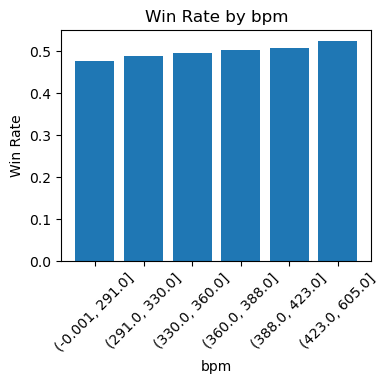

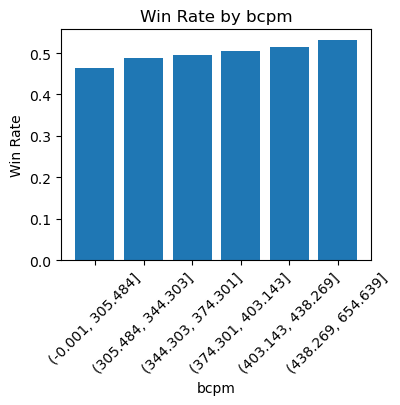

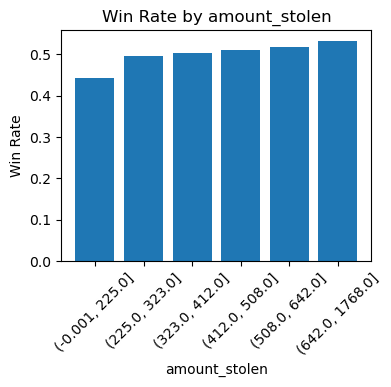

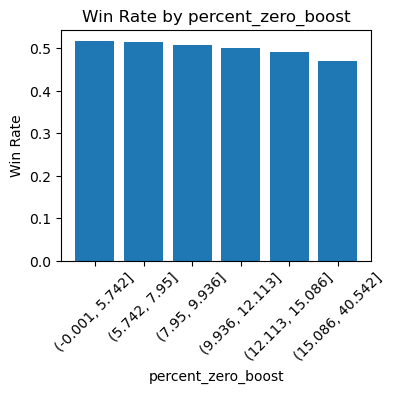

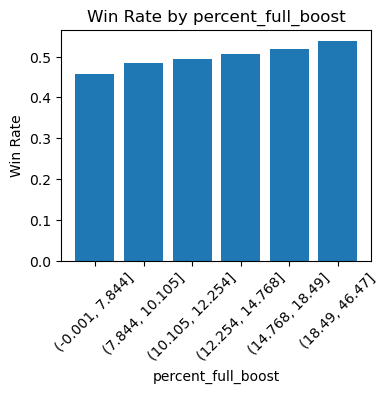

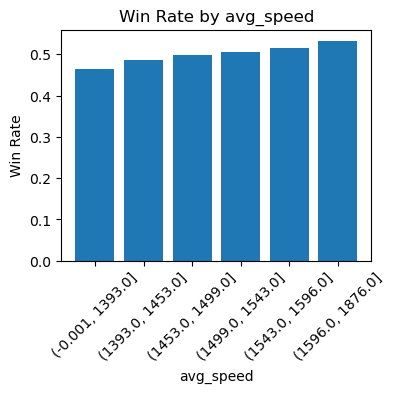

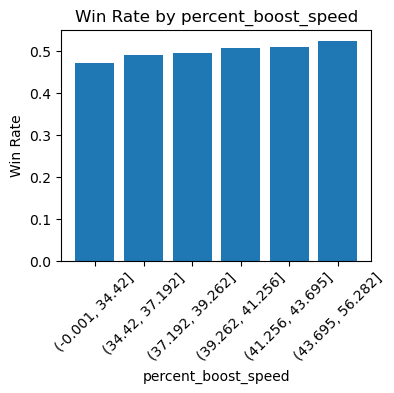

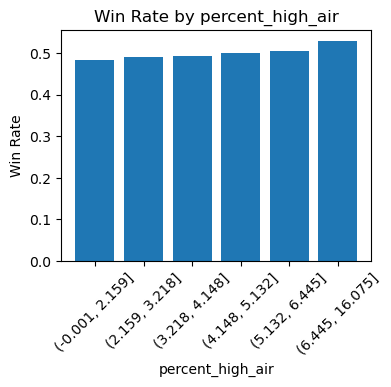

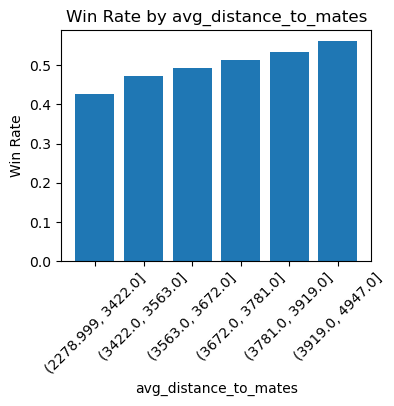

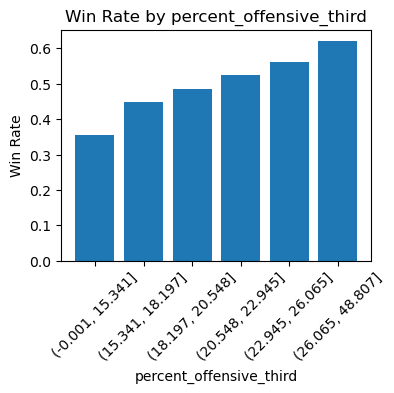

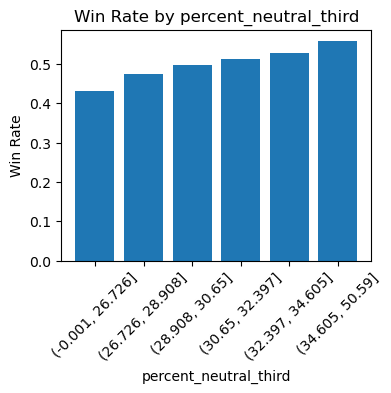

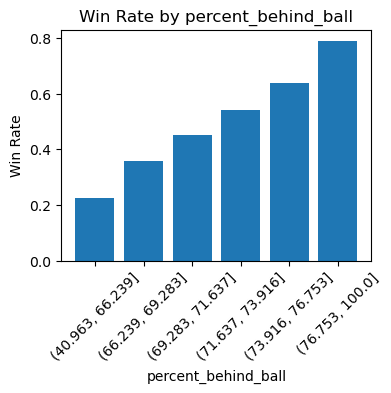

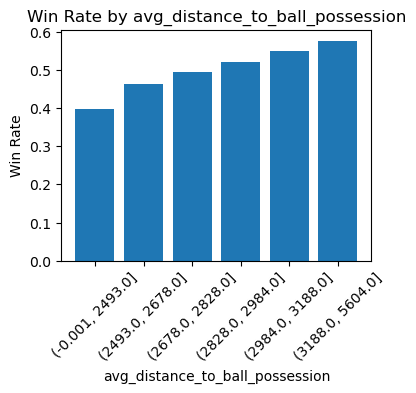

In [24]:
final_data_copy = final_data.copy()  # creating a copy of the dataframe to avoid changing the original at all

for feature in feature_cols:  # iterating through each feature from our list of 'feature_cols'
    final_data_copy['bin'] = pd.qcut(final_data_copy[feature], q=6)  # creating 6 equal-sized bins for each feature using qcut, which cuts the data into quantiles specified by q, for instance if q was 5, would cut data into lowest 20%, then 20 to 40%, 40 to 60% etc.
    
    win_rates = final_data_copy.groupby('bin')['win'].mean().reset_index()  # compute average win rate for each bin
    
    # Plot
    plt.figure(figsize=(4, 3)) # size not too big, since we are already iterating through a good number of features
    plt.bar(win_rates['bin'].astype(str), win_rates['win'])  # creating the bar plot of win rates
    plt.title(f'Win Rate by {feature}')  # plot titles
    plt.xlabel(feature)  # labeling the x-axis
    plt.ylabel('Win Rate')  # labeling the y-axis
    plt.xticks(rotation=45)
    plt.show()


# Preparing the Data and Modeling
After delving deeper into EDA and especially looking for correlated features with the correlation heatmap, I have removed more highly correlated columns and come up with my final list of features to model below. An example of features that I removed since Sprint 2 would be average distance to ball, as this averages out in general as there are times you are personally in possession as opposed to across field ready for a pass. Another example would be removing the percent_defensive_third, because that value is already implied since there are the features percent_offensive_third and percent_neutral_third.

Before modeling can happening, I need to extract my feature columns from the dataset and then append together the 6 rows that make up one game. I group by replay ID and seperate teams by color, looping through the feature columns for each team and adding them to the list. I also add a boolean 'winner' column that makes 1 a win for the blue team and a 0 a win for the orange team. Then creating column names, which makes for much better interpretability and seeing feature importance, then just turning it all back into a pandas dataframe.

For this final sprint, I chose to evaluate five different models: Logistic Regression, XGBoost, LightGBM, Random Forest, and CatBoost. Each of these models brings slightly different strengths to predicting Rocket League game outcomes. Below is a brief

1. Logistic Regression: Efficient and high interpretability in classification. It also provides a good baseline to compare other models too and offers insights into feature importance through coefficients.

2. XGBoost: Can handle more complex non-linear relationships while being resistant to overfitting. Performs well without much tinkering and doesn't take too long to train.

3. LightGBM: Trying a model thats tuned for speed and efficiency. Very fast to train.

4. Random Forest: Also effective in high-dimensional spaces and its ability to capture complex interactions. Takes a while to train though and I was often waiting for an hour or two for it to train.

5. CatBoost: Typically requires less hyperparameter tuning. It's designed to reduce overfitting and can perform on strange datasets, like this one.

These models allow us to try different approaches to this offbeat classification problem. I also tried Neural Networks but they take very long to train and I believe I simply dont have enough data (may need 10x more) after compressing the games and just seemed like the wrong model to use. I also stopped training SVM for similar reasons.

In [11]:
def prepare_game_data(final_data):
    games = [] # creating a list that will eventually be turned into a dataframe with all the final data
    
    for game_id, game_data in final_data.groupby('replay_id'):  # looping through each game in the dataset by replay id
        blue_team = game_data[game_data['team_color'] == 'blue']  # separating blue team data
        orange_team = game_data[game_data['team_color'] == 'orange']  # separating orange team data
        
        game_features = [] # creating a list to hold the features for the game
            
        for col in feature_cols:  # adding blue team features to the list
            game_features.extend(blue_team[col].tolist())
            
        for col in feature_cols:  # adding orange team features to the list
            game_features.extend(orange_team[col].tolist())
            
        winner = 1 if blue_team['win'].any() else 0  # determining the winner with 1 for blue & 0 for orange
            
        game_features.append(winner)  # adding the winner to the features list
            
        games.append(game_features)  # adding this game's features to the overall games list
    
    column_names = [f"{team}_{player}_{feature}"  # creating column names for our dataframe
                    for team in ['blue', 'orange'] 
                    for player in ['player1', 'player2', 'player3'] 
                    for feature in feature_cols]
    column_names.append('winner') # adding on the winner column
    
    df_games = pd.DataFrame(games, columns=column_names)  # creating a dataframe from the processed data
    
    return df_games

In [12]:
# using the function on the data
df_games = prepare_game_data(final_data)

In [25]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier 
from sklearn.inspection import permutation_importance

In [ ]:
X = df_games.iloc[:, :-1] #splitting up the data into x and y. the last column, 'winner', is y
y = df_games.iloc[:, -1]

### Splitting, Scaling and Model Definition
Here we are doing all the standard train/test splits and scaling of the data using Standard Scaler. We also got the 5 models I landed on and defining the parameter grids for gridsearch to search through and find the best combination of.

In [30]:
# I've switched up and consolidated the code for defining the models and added parameters for gridsearch
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=33)  # splitting data into training and test sets with an 80/20 split

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=33)  # creating validation set from training data

scaler = StandardScaler()  # initializing standard scaler for feature normalization
X_train_scaled = scaler.fit_transform(X_train)  # fitting scaler to training data and transforming it
X_val_scaled = scaler.transform(X_val)  # applying scaling to validation datta
X_test_scaled = scaler.transform(X_test)  # applying scaling to test data

models = {
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=1000),  # initializing logistic regression model
        'param_grid': { # picking some parameters for gridsearch to work on
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=33),  # initializing random forest model
        'param_grid': { # picking some parameters for gridsearch to work on
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],y
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "XGBoost": {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=33),  # initializing xgboost model
        'param_grid': { # picking some parameters for gridsearch to work on
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    },
    "LightGBM": {
        'model': lgb.LGBMClassifier(random_state=33),  # initializing lightgbm model
        'param_grid': { # picking some parameters for gridsearch to work on
            'n_estimators': [100, 200, 300],
            'num_leaves': [31, 63, 127],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    },
    "CatBoost": {
        'model': CatBoostClassifier(random_state=33, verbose=0),  # initializing catboost model
        'param_grid': { # picking some parameters for gridsearch to work on
            'iterations': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'depth': [4, 6, 8]
        }
    }
}

### Training and Storing Results
Here I loop through each model, giving myself a printed statement indicating which model is being trained on, defining and performing gridsearch, grabbing the best model and fitting the model to the data. Finally we store the relevant results to be printed later on. Out of these models, Random Forest took by far the longest to train, with the other models being fairly speedy. Before settling on these 5, I also trained SVM but that took a good 20 hours and produced no better results than that final 5 models.

In [24]:
results = {}  # dictionary to store results from each model
for name, model_info in models.items():  # looping through each model
    print(f"Training {name}")
    
    grid_search = GridSearchCV(model_info['model'], model_info['param_grid'], cv=5, scoring='accuracy', n_jobs=-1)  # setting up gridsearch with 5 cross-validation
    grid_search.fit(X_train_scaled, y_train)  # performing gridsearch to find best hyperparameters
    
    best_model = grid_search.best_estimator_  # getting the best model from gridsearch
    
    val_score = best_model.score(X_val_scaled, y_val)  # calculating validation score
    
    test_score = best_model.score(X_test_scaled, y_test)  # calculating test score
    y_pred = best_model.predict(X_test_scaled)  # making predictions on test set
    
    results[name] = {
        "best_estimator": best_model,  # storing the best model from the grid search
        "best_params": grid_search.best_params_,  # storing best hyperparameters
        "best_cv_score": grid_search.best_score_,  # storing best cross-validation score
        "validation_score": val_score,  # storing validation score
        "test_score": test_score,  # storing test score
        "classification_report": classification_report(y_test, y_pred),  # generating  and storing classification report
        "confusion_matrix": confusion_matrix(y_test, y_pred)  # generatng and storing confusion matrix
    }

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 31693, number of negative: 32275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 63968, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495451 -> initscore=-0.018197
[LightGBM] [Info] Start training from score -0.018197
Training CatBoost...


### Results
Looping through results and printing all relevant information.

In [26]:
for name, result in results.items(): # looping through the results and printing them all out
    print(f"\n{name} Results:")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Cross-validation Score: {result['best_cv_score']:.4f}")
    print(f"Validation Score: {result['validation_score']:.4f}")
    print(f"Test Score: {result['test_score']:.4f}")
    print("Classification Report:")
    print(result['classification_report'])
    print("Confusion Matrix:")
    print(result['confusion_matrix'])


Logistic Regression Results:
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-validation Score: 0.7955
Validation Score: 0.7948
Test Score: 0.7926
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     10112
           1       0.79      0.79      0.79      9879

    accuracy                           0.79     19991
   macro avg       0.79      0.79      0.79     19991
weighted avg       0.79      0.79      0.79     19991

Confusion Matrix:
[[8025 2087]
 [2060 7819]]

Random Forest Results:
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Cross-validation Score: 0.8056
Validation Score: 0.8102
Test Score: 0.8071
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     10112
           1       0.81      0.80      0.80      9879

    accuracy                    

### Feature Importance
Here we are looking at how each model values each feature. It is interesting to see that it is actually average distance to teammates that tops the list for each model. This helps with interpretability and helping us understand how the models are working.

In [27]:
full_feature_list = [f"{team}_{feature}" for team in ['blue', 'orange'] for feature in feature_cols]  # creating full feature list for both teams
for name in ["Random Forest", "XGBoost", "LightGBM", "CatBoost"]:  # iterating through relevant models
    if name in models:
        print(f"\n{name} Feature Importance:")
        best_model = results[name]['best_estimator']  # getting best model from results
        if hasattr(best_model, 'feature_importances_'):  # checking if model has feature importances, not super necessary for this application as I know they do, but for future work I was practicing
            importance = best_model.feature_importances_  # extracting feature importances
            feature_importance = sorted(zip(full_feature_list, importance), key=lambda x: x[1], reverse=True)  # sorting features by importance in descending order
            for feature, importance in feature_importance:
                print(f"{feature}: {importance:.4f}")  # printing each features importance
        else:
            print("WHoopsies")  # error message


Random Forest Feature Importance:
blue_avg_distance_to_mates: 0.0103
blue_percent_boost_speed: 0.0101
blue_percent_high_air: 0.0099
orange_avg_distance_to_mates: 0.0088
blue_percent_offensive_third: 0.0082
orange_bcpm: 0.0082
orange_percent_neutral_third: 0.0081
blue_avg_distance_to_ball_possession: 0.0081
orange_percent_offensive_third: 0.0081
blue_percent_neutral_third: 0.0080
orange_bpm: 0.0080
blue_percent_behind_ball: 0.0079
orange_avg_speed: 0.0079
orange_percent_boost_speed: 0.0079
orange_percent_high_air: 0.0077
orange_percent_behind_ball: 0.0076
orange_amount_stolen: 0.0076
orange_avg_distance_to_ball_possession: 0.0075
blue_avg_speed: 0.0075
blue_percent_full_boost: 0.0075
orange_percent_zero_boost: 0.0074
orange_percent_full_boost: 0.0074
blue_percent_zero_boost: 0.0072
blue_bpm: 0.0072
blue_bcpm: 0.0072
blue_amount_stolen: 0.0070

XGBoost Feature Importance:
orange_avg_distance_to_mates: 0.0118
orange_percent_neutral_third: 0.0102
orange_percent_offensive_third: 0.0101
blu

### Receiver Operating Characteristic (ROC) Curve
Here we can see the ROC curve for each of our models, showing the trade off between correctly identifying winners (true positive rate) vs mistakeningly identifying losers as winners (false positive rate). A perfect model would hug the top left corner, and while not perfect, our models do pretty well here, falling inbetween .88 and .90.

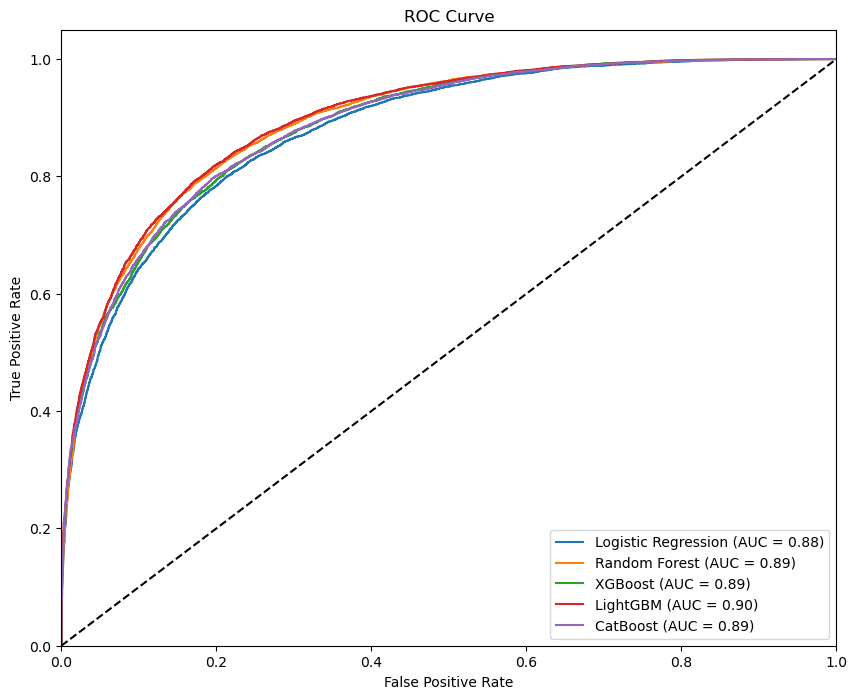

In [35]:
plt.figure(figsize=(10, 8))  # creating new figure for roc curve plot
for name, result in results.items(): #loop through results
    model = result['best_estimator']  # getting best model
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # predicting probabilities
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # calculating false and true positive rates
    roc_auc = auc(fpr, tpr)  # calculating area under roc curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')  # plot roc for current model

plt.plot([0, 1], [0, 1], 'k--')  # adding diagonal line representing the random classifier
plt.xlim([0.0, 1.0])  # setting x axis limits
plt.ylim([0.0, 1.05])  # setting y axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')  # title
plt.legend(loc="lower right")  # legend
plt.show()

### Model Performance Comparision
As noted above, all models were relatively similar. Not much else to say here.

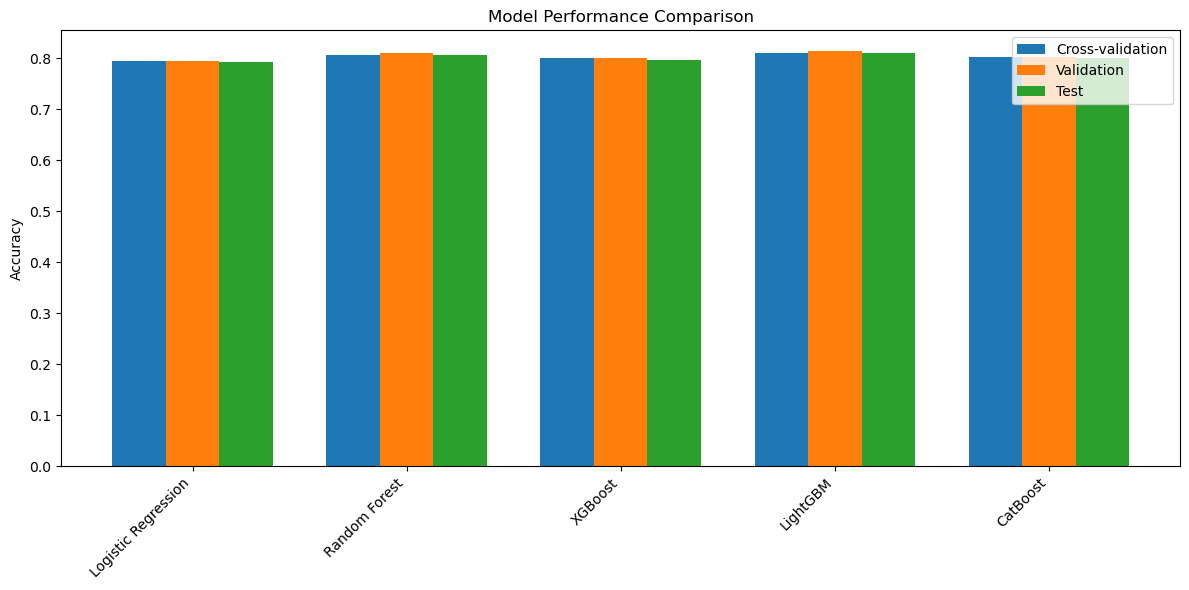

In [29]:
names = list(results.keys())  # getting list of model names
cv_scores = [result['best_cv_score'] for result in results.values()]  # grabbing cv scores
val_scores = [result['validation_score'] for result in results.values()]  # grabbing validation scores
test_scores = [result['test_score'] for result in results.values()]  # grabbing test scores

x = np.arange(len(names))  # x coords for bar plot
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(12, 6))  # new figure for bar plot
ax.bar(x - width, cv_scores, width, label='Cross-validation')  # plotting cross-validation scores
ax.bar(x, val_scores, width, label='Validation')  # plotting validation scores
ax.bar(x + width, test_scores, width, label='Test')  # plotting test scores

ax.set_ylabel('Accuracy')  # y-axis
ax.set_title('Model Performance Comparison')  # title
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')  # labeling xaxis with the model names
ax.legend()  # legend
plt.tight_layout()  # TOIGHT layout
plt.show()  # displaying the plot

## Testing New Data on the Models
To test new data we just have to perform basically all the same operations on the new data to put it in a form that the models can process.

In [ ]:
def predict_new_games(new_data, model_name):
    prepared_new_data = prepare_game_data(new_data)  # using same function to prepare the new data
    
    X_new = prepared_new_data.iloc[:, :-1]  # separating features from winner column
    
    X_new_scaled = scaler.transform(X_new)  # scaling the features the same as like with training
    
    model = models[model_name]['best_estimator']  # getting the best model from the gridsearch
    
    predictions = model.predict(X_new_scaled)  # predicting with the model
    probabilities = model.predict_proba(X_new_scaled)  # getting prediction probabilities
    
    prepared_new_data['predicted_winner'] = predictions  # adding predictions to the dataframe
    prepared_new_data['blue_win_probability'] = probabilities[:, 1]  # adding blue win probabilities
    
    prepared_new_data['predicted_outcome'] = prepared_new_data['predicted_winner'].map({1: 'Blue Win', 0: 'Orange Win'}) # interpreting results making 1 blue win and 0 orange win
    
    return prepared_new_data[['predicted_outcome', 'blue_win_probability']]

In [ ]:
# Example for how we would use the function to print results.
results = predict_games(data, 'Logistic Regression')
print(results)

# Modeling Conclusion and Final Notes
As we can see from the results and training time, I believe there to be a clear winner in LightGBM. Not only did it perform slightly better in all aspects when compared to the other models, it was also one of the quickest to train, only being outperformed in that area by standard Logistic Regression. LightGBM is in general a good model for large datasets that uses paralellization and a unique "leaf-wise" structure that allows faster training and quite good performance without too much tinkering. Going forward, I will be packaging this model into a simple app that my colleagues at 9Moons can use to predict games in our tournaments for some more fun and interesting topics to discuss during pre-game analysis.

I was a bit disappointed that despite doubling the amount of data and doing extensive feature egineering and modeling, I was never able to achieve higher than a 82% accuracy score (this score was in fact lost to re-training of models while I attempted to improve performance, but was also achieved by LightGBM). I believe that with 10x or more data and possibly a well optimized LightGBM, SVM or Neural Network, a score of 85% may be possible, but hard to say. The reality of working with this sort of tertiary stats data is that random things happen in game to swing it in favor of one team or another and none of these stats directly relate to goals. Even if they did and I was using more mainline stats, the prediction would still not be perfect. I think that given the way I decided to go about this with only using tertiary stats (no goals/assists/saves/etc) 81-82% is quite a good score and I am excited to use this in our 9Moons events. I would also like to apply what I have learned here to possibly creating other prediction models that may have a more real world benefit to them. Although this was fun and part of an area of interest of mine, I recognize that it's application is quite limited. All that being said, I've certainly learned alot and am ready to move onto the next challenge!